In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import gym
from gym import spaces
from gym.spaces import Box, Discrete
from collections import deque
import itertools
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler
import warnings
import os
import pickle
warnings.filterwarnings("ignore")

# create random number generator
rng = np.random.default_rng()

In [2]:
def get_data(name):
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv(name)
  return df.values    # get a numpy array
                      # each row corresponds to one day

# 1st Split

In [3]:
train_1st = get_data("UltimateStocks.csv")[:-440]
train_1st

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [185.160004, 107.309998,  57.450001],
       [186.050004, 107.839996,  57.669998],
       [187.36    , 105.779999,  57.040001]])

In [4]:
test_1st = get_data("UltimateStocks.csv")[-440:]
test_1st

array([[190.039992, 108.75    ,  57.650002],
       [188.589996, 108.370003,  57.27    ],
       [188.149992, 107.379997,  57.130001],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

# 2nd split

In [5]:
train_2nd = get_data("train_2nd.csv")
train_2nd

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [6]:
test_2nd = get_data("test_2nd.csv")
test_2nd

array([[108.      ,  74.28    ,  55.62    ],
       [107.93    ,  75.52    ,  55.47    ],
       [108.18    ,  74.54    ,  55.47    ],
       ...,
       [185.160004, 107.309998,  57.450001],
       [186.050004, 107.839996,  57.669998],
       [187.36    , 105.779999,  57.040001]])

# 3rd split

In [7]:
train_3rd = get_data("train_3rd.csv")
train_3rd

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [8]:
test_3rd = get_data("test_3rd.csv")
test_3rd

array([[108.83 ,  63.94 ,  38.825],
       [109.7  ,  63.55 ,  38.865],
       [111.25 ,  63.7  ,  38.925],
       ...,
       [107.48 ,  73.5  ,  55.9  ],
       [108.37 ,  73.93 ,  55.36 ],
       [108.81 ,  74.28 ,  55.2  ]])

# 4th split

In [9]:
train_4th = get_data("train_4th.csv")
train_4th

array([[108.7     ,  63.42    ,  38.725   ],
       [109.01    ,  64.14    ,  38.895   ],
       [108.83    ,  63.94    ,  38.825   ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [10]:
test_4th = get_data("test_4th.csv")
test_4th

array([[ 67.8542,  60.3   ,  28.185 ],
       [ 68.5614,  60.9   ,  28.07  ],
       [ 66.8428,  60.83  ,  28.13  ],
       ...,
       [109.4   ,  64.68  ,  38.05  ],
       [108.6   ,  66.76  ,  38.355 ],
       [108.86  ,  64.46  ,  38.33  ]])

In [11]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here
  # To get parameter for the scaler, we must have some data
  # --> play an episode randomly and store each of the states we encounter. No need for an agent
  # For more accurate, run multiple episodes

  states = []
  for _ in range(env.n_step):
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    states.append(state)
    if terminated:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler


In [12]:
class MultiStockEnv(gym.Env):

  def __init__(self, data, initial_investment=20000):             # data = return of get_data()
    # data                                                        # get_data() returns a numpy array
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape    # (# day, 3)

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price_last2 = None
    self.stock_price_yesterday = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = Discrete(343)
    self.action_list = list(map(list, itertools.product([-1, -2/3, -1/3, 0, 1/3, 2/3, 1], repeat=self.n_stock)))
                                               # -1 = sell all stocks
                                               # 0 = hold
                                               # 1 = buy with all of our money

    # calculate size of state
    self.state_dim = self.n_stock * 4 + 1      # If we have N stocks, the state contains 4N+1 dimensions

    self.reset()


  def reset(self):
    self.cur_step = 2                                                         # 3rd day of stock prices
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price_last2 = self.stock_price_history[self.cur_step - 2]      # Stock price of each stock on the last two day
    self.stock_price_yesterday = self.stock_price_history[self.cur_step - 1]  # Stock price of each stock yesterday
    self.stock_price = self.stock_price_history[self.cur_step]                # Stock price of each stock on the current day
    self.cash_in_hand = self.initial_investment                 # Not yet buy any stock, only initial investment
    return self._get_obs()                                      # Return the first state vector, done by get_obs()
                                                    # [0, 0, 0, 67.8542, 60.3, 28.185, 
                                                    #           68.5614, 60.9, 28.07, 
                                                    #           66.8428, 60.83, 28.13, 20000])



  def step(self, action):
    # assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1

    self.stock_price = self.stock_price_history[self.cur_step]    # day -> next day, price -> price for next day
                                                                  # self.stock_price_history = data = train_data -- a numpy array
    self.stock_price_last2 = self.stock_price_history[self.cur_step - 2]      # Stock price on the last two day
    self.stock_price_yesterday = self.stock_price_history[self.cur_step - 1]  # Stock price yesterday
    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val 
    # done if we have run out of data
    terminated = self.cur_step == self.n_step - 1             # True when we reach the end of the series
                                                        # Realistically, stock markets never end, there is no termination
                                                        # In here, our code ends when there is no more data
    # store the current value of the portfolio here
    info = {'cur_val': cur_val}


    # conform to the Gym API
    return self._get_obs(), reward, terminated, False, info



  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned                              # List of 3, stock owned

    obs[self.n_stock:2*self.n_stock] = self.stock_price_last2          # List of 3, stock price
    obs[2*self.n_stock:3*self.n_stock] = self.stock_price_yesterday    # List of 3, stock price
    obs[3*self.n_stock:4*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand                                        # Cash in hands for last index
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand    # Total money



  def _trade(self, action):
    action_vec = self.action_list[action]     # returns a list of size 3

    # determine which stocks to buy or sell, we need this so that we can always buy before selling
    sell_info = [] # stores index and portion of stocks we want to sell
    buy_info = []  # stores index and portion of stocks we want to buy
        
    for i, a in enumerate(action_vec):   
      if a < 0:
        sell_info.append([i,a])      # gonna sell
        
      elif a > 0:
        buy_info.append([i,a])       # gonna buy
    # print('buy_info', buy_info)
    # print('sell_info', sell_info)
    

    # Buy before sell so that the money got from selling is only available in the next time-step
    if buy_info:
      new_action = []           # to store the actions only, which do not necessarily sum to 1 
      for (i,a) in buy_info: 
        new_action.append(a)
      
      if np.sum(new_action) > 1:        # Only softmax when their sum > 1
        new_buy = softmax(new_action)   # softmax so they sum to 1
      else:
        new_buy = new_action            # Keep the old action

      for i in range(len(buy_info)):
        buy_info[i][1] = new_buy[i]     # overwriting buy_info with our new softmaxed actions, or not
      # print(buy_info)
    

      total_cash_spent = 0                             # Need this so that we only subtract when we finish buying all stocks, to prevent overwriting self.cash_in_hand
      for (i,a) in buy_info:                           # If we buy, we buy using a% of our cash_in_hand
        cash_to_spend = self.cash_in_hand*a           
        if cash_to_spend > self.stock_price[i]:          # Check if we can afford at least 1 stock
          stock_bought = cash_to_spend // self.stock_price[i]
          self.stock_owned[i] += stock_bought
          cash_spent = stock_bought * self.stock_price[i]
          total_cash_spent += cash_spent
      total_cash_spent += total_cash_spent*0.0001   # 0.01% trade fee
      self.cash_in_hand -= total_cash_spent


    # Sell after buy
    if sell_info:                                   # [] - empty list also treated as None
      for (i,a) in sell_info:                       # If we sell, we sell a% of our stock_owned 
        stock_sold = -int(self.stock_owned[i]*a)    # minus because a is negative
        # print(stock_sold)
        self.stock_owned[i] -= stock_sold
        cash_increase = self.stock_price[i] * stock_sold
        self.cash_in_hand += cash_increase - cash_increase*0.0001  # 0.01% trade fee

# Dueling DDQN

In [13]:
# Dueling Q-network for approximating action-value function
class DuelingQNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()
        
        # input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
        
        # special layer (state value and action advantage)
        layers.append(nn.Linear(hidden_sizes[-1], output_size + 1))

        # output layer (weights are fixed, bias is zero)
        output = nn.Linear(output_size+1, output_size, bias=False)
        layers.append(output)
    
        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)
        
        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)
        
        # initialise the weights according to dueling network architecture
        weights = torch.zeros((output_size, output_size+1))
        weights[:, 0] = 1.
        weights[:, 1:] = torch.eye(output_size)
        weights[:, 1:] -= 1./output_size
        output.weight.requires_grad = False
        output.weight[:] = weights
        
    
    def forward(self, x):
        # return output of Q-network for the input x
        return self.net(x)
    
    def update(self, inputs, targets):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        outputs = self.net(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
    
    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

In [14]:
# Dueling Double Deep Q-network with Prioritised Experience Replay
class AgentDuelingDDQNREP():
    def __init__(self, env, gamma, scaler,
                 hidden_sizes=(32, 32),
                 learning_rate=0.001,
                 epsilon=0.1,
                 rep_omega=0.2,
                 replay_size=10000,
                 minibatch_size=32,
                 target_update=20):        
        
        self.state_dims = env.state_dim

        
        # check if the action space has correct type
        assert isinstance(env.action_space, spaces.Discrete), 'Action space must be discrete'
        self.num_actions = env.action_space.n
        
        # create dueling Q-networks for action-value function
        self.qnet = DuelingQNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)
        self.target_qnet = DuelingQNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)
        
        # copy weights from Q-network to target Q-network
        self.target_qnet.copy_from(self.qnet)
        
        # initialise replay buffer
        self.replay = deque(maxlen=replay_size)
        
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        self.rep_omega = rep_omega
        self.minibatch_size = minibatch_size
        self.target_update = target_update
        self.target_update_idx = 0
        self.scaler = scaler
        
    def behaviour(self, state):
        # exploratory behaviour policy
        if rng.uniform() >= self.epsilon:
            # convert state to torch format
            if not torch.is_tensor(state):
                state = torch.tensor(state, dtype=torch.float)
            
            # exploitation with probability 1-epsilon; break ties randomly
            q = self.qnet(state).detach()
            j = rng.permutation(self.num_actions)
            return j[q[j].argmax().item()]
        else:
            # exploration with probability epsilon
            return self.env.action_space.sample()        
        
    def policy(self, state):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)
        
        # greedy policy
        q = self.qnet(state).detach()
        return q.argmax().item()
    
    def td_error(self, state, action, reward, next_state, terminated):
        # calculate td error for prioritised experience replay
        q = self.qnet(state).detach()
        if terminated:
            return np.abs(reward - q[action].item())**self.rep_omega
        else:
            next_action = self.qnet(next_state).detach().argmax()
            next_q = self.target_qnet(next_state).detach()
            return np.abs(reward + self.gamma*next_q[next_action] - q[action].item())**self.rep_omega

    def update(self):
        # update Q-network if there is enough experience
        if len(self.replay) >= self.minibatch_size:
            # select mini-batch of experiences using prioritised experience replay
            p_rep = np.array([self.replay[i][-1] for i in range(len(self.replay))])
            p_rep = p_rep/p_rep.sum()
            minibatch = rng.choice(self.replay, size=self.minibatch_size, p=p_rep, replace=False)
            
            # calculate inputs and targets for the transitions in the mini-batch
            inputs = torch.zeros((self.minibatch_size, self.state_dims))
            targets = torch.zeros((self.minibatch_size, self.num_actions))
            
            for n, (state, action, reward, next_state, terminated, _) in enumerate(minibatch):
                # inputs are states
                inputs[n, :] = state
                
                # targets are TD targets
                targets[n, :] = self.target_qnet(state).detach()
                if terminated:
                    targets[n, action] = reward
                else:
                    # double learning
                    # note: we don't break ties randomly (ties are unlikely when weights are initialised randomly)
                    next_action = self.qnet(next_state).detach().argmax()             # Take the best action from the online q
                    next_q = self.target_qnet(next_state).detach()                    # Get the next target q
                    targets[n, action] = reward + self.gamma*next_q[next_action]      # put the action in the target q to evaluate it
            
            # train Q-network on the mini-batch
            self.qnet.update(inputs, targets)
        
        # periodically copy weights from Q-network to target Q-network
        self.target_update_idx += 1
        if self.target_update_idx % self.target_update == 0:
            self.target_qnet.copy_from(self.qnet)
            
    def train(self, max_episodes, stop_criterion, criterion_episodes):
        # train the agent for a number of episodes
        rewards = []
        num_steps = 0
        for episode in range(max_episodes):
            print(f'epsilon: {self.epsilon}')

            state = env.reset()
            state = self.scaler.transform([state]).reshape(-1,)

            # convert state to torch format
            state = torch.tensor(state, dtype=torch.float)

            terminated = False
            truncated = False
            rewards.append(0)
            while not (terminated or truncated):
                # select action by following behaviour policy
                action = self.behaviour(state)

                # send the action to the environment
                next_state, reward, terminated, truncated, info = env.step(action)
                next_state = self.scaler.transform([next_state]).reshape(-1,)


                # convert next state to torch format
                next_state = torch.tensor(next_state, dtype=torch.float)
                
                # calculate td error for prioritised experience replay and add experience to replay buffer
                per = self.td_error(state, action, reward, next_state, terminated)
                self.replay.append((state, action, reward, next_state, terminated, per))                
                
                # update Q-network
                self.update()

                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay
                
                state = next_state
                rewards[-1] += reward
                num_steps += 1

            val = info['cur_val']    
            print(f'\rEpisode {episode+1} done: steps = {num_steps}, rewards = {rewards[episode]}, portfolio = {val}     ', end='')
            
            if episode >= criterion_episodes-1 and stop_criterion(rewards[-criterion_episodes:]):
                print(f'\nStopping criterion satisfied after {episode} episodes')
                break
            
        # plot rewards received during training
        plt.figure(dpi=100)
        plt.plot(range(1, len(rewards)+1), rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()    
    
    def save(self, path):
        # save network weights to a file
        torch.save(self.qnet.state_dict(), path)
        
    def load(self, path):
        # load network weights from a file
        self.qnet.load_state_dict(torch.load(path))
        self.target_qnet.copy_from(self.qnet)

___

# 1st Split

**Do not need to re-train the agent, we have saved all the agents in their corresponding folders, Just need to load the agent (with correct scaler) to observe the test set**

epsilon: 1.0
Episode 1 done: steps = 1319, rewards = 27475.456688318525, portfolio = 47475.456688318525     epsilon: 0.0996820918179746
Episode 2 done: steps = 2638, rewards = 64247.7125160413, portfolio = 84247.7125160413     epsilon: 0.0996820918179746
Episode 3 done: steps = 3957, rewards = 26985.814676488924, portfolio = 46985.814676488924     epsilon: 0.0996820918179746
Episode 4 done: steps = 5276, rewards = 24380.8288828569, portfolio = 44380.8288828569     epsilon: 0.0996820918179746
Episode 5 done: steps = 6595, rewards = 26118.56563891261, portfolio = 46118.56563891261     epsilon: 0.0996820918179746
Episode 6 done: steps = 7914, rewards = 32139.457369981115, portfolio = 52139.457369981115     epsilon: 0.0996820918179746
Episode 7 done: steps = 9233, rewards = 13278.970403713996, portfolio = 33278.970403713996     epsilon: 0.0996820918179746
Episode 8 done: steps = 10552, rewards = 12686.11016867591, portfolio = 32686.11016867591     epsilon: 0.0996820918179746
Episode 9 done

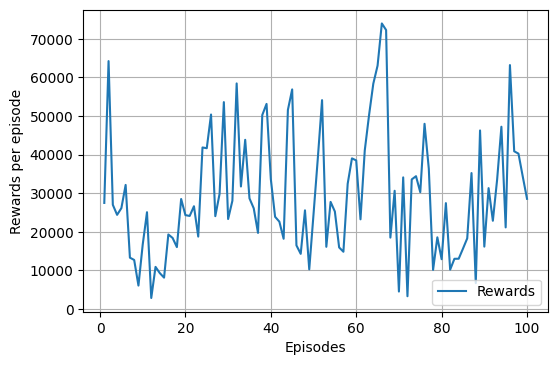

Reward: 46229.583634976836, info: 66229.58363497684


In [15]:
data = train_1st

env = MultiStockEnv(data)


gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 1.0
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=scaler)


agent.train(max_episodes, lambda x : min(x) >= 150000, criterion_episodes)    # at most $150,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')


In [ ]:
folder = 'DuelingDDQN_128x128_New'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDuelingDDQN.128x128_1st_New.pt')

with open(f'{folder}/DuelingDDQN_128x128_scaler_1st_New.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test The Agent**

In [15]:
data = test_1st

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.1
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

folder = 'DuelingDDQN_128x128_New'
with open(f'{folder}/DuelingDDQN_128x128_scaler_1st_New.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 

# test_scaler = get_scaler(env)


agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=test_scaler)




agent.load(f'{folder}/tradingbotDuelingDDQN.128x128_1st_New.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

Reward: 23976.042033475198, info: 43976.0420334752


In [ ]:
a = np.array(portfolio)
np.save('npy/DuelingDQN_New_Test1.npy', a)

___

# 2nd Split

epsilon: 1.0
Episode 1 done: steps = 1319, rewards = 32638.510753636758, portfolio = 52638.51075363676     epsilon: 0.0996820918179746
Episode 2 done: steps = 2638, rewards = 36980.8846204884, portfolio = 56980.8846204884     epsilon: 0.0996820918179746
Episode 3 done: steps = 3957, rewards = 36083.35608655149, portfolio = 56083.35608655149     epsilon: 0.0996820918179746
Episode 4 done: steps = 5276, rewards = 45670.67506883327, portfolio = 65670.67506883327     epsilon: 0.0996820918179746
Episode 5 done: steps = 6595, rewards = 24158.374964500617, portfolio = 44158.37496450062     epsilon: 0.0996820918179746
Episode 6 done: steps = 7914, rewards = 19355.188379261795, portfolio = 39355.188379261795     epsilon: 0.0996820918179746
Episode 7 done: steps = 9233, rewards = 21512.72483902129, portfolio = 41512.72483902129     epsilon: 0.0996820918179746
Episode 8 done: steps = 10552, rewards = 33005.30053385643, portfolio = 53005.30053385643     epsilon: 0.0996820918179746
Episode 9 done: 

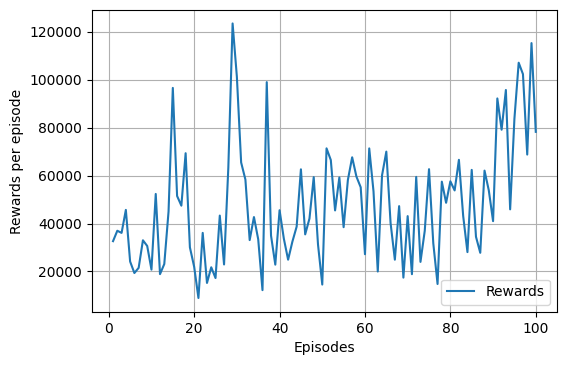

Reward: 64864.81072121671, info: 84864.81072121671


In [ ]:
data = train_2nd

env = MultiStockEnv(data)


gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 1.0
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=scaler)


agent.train(max_episodes, lambda x : min(x) >= 150000, criterion_episodes)    # at most $150,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

In [ ]:
folder = 'DuelingDDQN_128x128_New'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDuelingDDQN.128x128_2nd_New.pt')

with open(f'{folder}/DuelingDDQN_128x128_scaler_2nd_New.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test The Agent**

In [16]:
data = test_2nd

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.1
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

folder = 'DuelingDDQN_128x128_New'
with open(f'{folder}/DuelingDDQN_128x128_scaler_2nd_New.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 




agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=test_scaler)


agent.load(f'{folder}/tradingbotDuelingDDQN.128x128_2nd_New.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []

while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

Reward: 9951.145694887018, info: 29951.145694887018


In [ ]:
a = np.array(portfolio)
np.save('npy/DuelingDQN_New_Test2.npy', a)

___

# 3rd Split

epsilon: 1.0
Episode 1 done: steps = 1319, rewards = 25533.26941543418, portfolio = 45533.26941543418     epsilon: 0.0996820918179746
Episode 2 done: steps = 2638, rewards = 51608.7827215843, portfolio = 71608.7827215843     epsilon: 0.0996820918179746
Episode 3 done: steps = 3957, rewards = 43968.90406741339, portfolio = 63968.90406741339     epsilon: 0.0996820918179746
Episode 4 done: steps = 5276, rewards = 38607.552392481986, portfolio = 58607.552392481986     epsilon: 0.0996820918179746
Episode 5 done: steps = 6595, rewards = 37209.84254434961, portfolio = 57209.84254434961     epsilon: 0.0996820918179746
Episode 6 done: steps = 7914, rewards = 40535.35204074359, portfolio = 60535.35204074359     epsilon: 0.0996820918179746
Episode 7 done: steps = 9233, rewards = 39742.5283896531, portfolio = 59742.5283896531     epsilon: 0.0996820918179746
Episode 8 done: steps = 10552, rewards = 41481.99838196388, portfolio = 61481.99838196388     epsilon: 0.0996820918179746
Episode 9 done: step

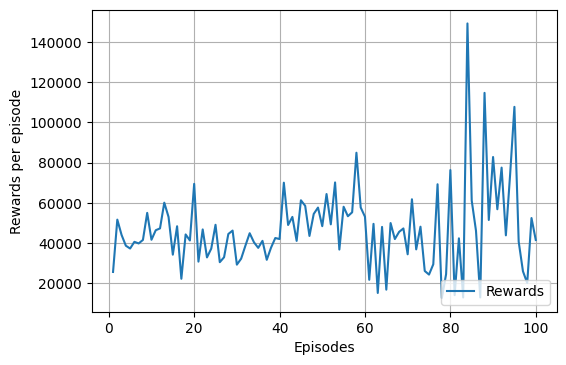

Reward: 216664.94616988502, info: 236664.94616988502


In [ ]:
data = train_3rd

env = MultiStockEnv(data)


gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 1.0
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=scaler)


agent.train(max_episodes, lambda x : min(x) >= 150000, criterion_episodes)    # at most $150,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')


In [ ]:
folder = 'DuelingDDQN_128x128_New'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDuelingDDQN.128x128_3rd_New.pt')

with open(f'{folder}/DuelingDDQN_128x128_scaler_3rd_New.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test The Agent**

In [17]:
data = test_3rd

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.1
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

folder = 'DuelingDDQN_128x128_New'
with open(f'{folder}/DuelingDDQN_128x128_scaler_3rd_New.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 


agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=test_scaler)




agent.load(f'{folder}/tradingbotDuelingDDQN.128x128_3rd_New.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []

while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

Reward: 13784.033182999992, info: 33784.03318299999


In [ ]:
a = np.array(portfolio)
np.save('npy/DuelingDQN_New_Test3.npy', a)

___

# 4th Split

epsilon: 1.0
Episode 1 done: steps = 1319, rewards = 37096.74750686712, portfolio = 57096.74750686712     epsilon: 0.0996820918179746
Episode 2 done: steps = 2638, rewards = 23625.403436993984, portfolio = 43625.40343699398     epsilon: 0.0996820918179746
Episode 3 done: steps = 3957, rewards = 36791.75296714302, portfolio = 56791.75296714302     epsilon: 0.0996820918179746
Episode 4 done: steps = 5276, rewards = 54759.60968573806, portfolio = 74759.60968573806     epsilon: 0.0996820918179746
Episode 5 done: steps = 6595, rewards = 41950.117650415224, portfolio = 61950.117650415224     epsilon: 0.0996820918179746
Episode 6 done: steps = 7914, rewards = 32258.572682882914, portfolio = 52258.572682882914     epsilon: 0.0996820918179746
Episode 7 done: steps = 9233, rewards = 49367.940969158575, portfolio = 69367.94096915858     epsilon: 0.0996820918179746
Episode 8 done: steps = 10552, rewards = 47963.44515396247, portfolio = 67963.44515396247     epsilon: 0.0996820918179746
Episode 9 do

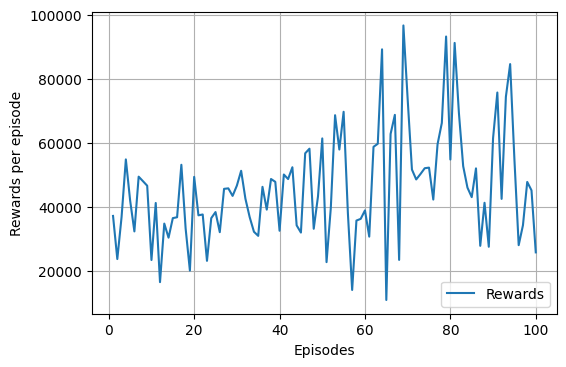

Reward: 21552.632470435696, info: 41552.632470435696


In [ ]:
data = train_4th

env = MultiStockEnv(data)


gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 1.0
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=scaler)


agent.train(max_episodes, lambda x : min(x) >= 150000, criterion_episodes)    # at most $150,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')


In [ ]:
folder = 'DuelingDDQN_128x128_New'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDuelingDDQN.128x128_4th_New.pt')

with open(f'{folder}/DuelingDDQN_128x128_scaler_4th_New.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test The Agent**

In [16]:
data = test_4th

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.1
rep_omega = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 5000
criterion_episodes = 5

folder = 'DuelingDDQN_128x128_New'
with open(f'{folder}/DuelingDDQN_128x128_scaler_4th_New.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 


agent = AgentDuelingDDQNREP(env,
                            gamma=gamma,
                            hidden_sizes=hidden_sizes,
                            learning_rate=learning_rate,
                            epsilon=epsilon,
                            rep_omega=rep_omega,
                            replay_size=replay_size,
                            minibatch_size=minibatch_size,
                            target_update=target_update,
                            scaler=test_scaler)




agent.load(f'{folder}/tradingbotDuelingDDQN.128x128_4th_New.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []

while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

Reward: 19365.067150750023, info: 39365.06715075002


In [ ]:
a = np.array(portfolio)
np.save('npy/DuelingDQN_New_Test4.npy', a)